# Wetterstation Kloten

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import interp1d
from scipy import integrate
from scipy import optimize

1. Import der Daten
   - Beschreibt die Datenstruktur.
   - Zeigt auf, wie viele Messungen es sind.

In [2]:
#load csv file
weather = np.loadtxt('Zürich21-22-GruppeG.csv', skiprows=1, delimiter=';', dtype=str)

#select data for Kloten
klo_weather = [row for row in weather if row[0] == 'KLO'] #klo_weather is a list of lists or Numpy array???

In [3]:
#Daten transponieren
klo_weather_t = np.transpose(klo_weather)

time = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in klo_weather_t[1]]
pressure = klo_weather_t[2].astype(float)
temp = klo_weather_t[3].astype(float)
rain = klo_weather_t[4].astype(float)
sunshine = klo_weather_t[5].astype(float)
time_diff = klo_weather_t[6].astype(float)

In [4]:
print("Anzahl Messungen:", len(klo_weather))

Anzahl Messungen: 7473


- #stn: Stationnummer oder ID der Wetterstation
- time: Zeitpunkt der Messung im Format JJJJMMDDhhmm
- prestah0: Luftdruck auf Stationshöhe (in hPa)
- tre200h0: Lufttemperatur in 2m Höhe (in Grad Celsius)
- rre150h0: Niederschlagssumme (in mm) der letzten 6 Minuten
- su2000h0: Sonnenscheindauer in Minuten der letzten Stunde
- time_diff: Zeitdifferenz zur vorigen Messung in Minuten

2. Da einige Datenpunkte fehlen, müsst ihr diese interpolieren.
   - Wählt dazu eine geeignete Methode und begründet eure Wahl.
   - Führt die Methode durch, um eine interpolierte Version der Daten mit mindestens doppelt so vielen Punkten zu erzeugen.

In [5]:
#daten für demo
time_diff_demo = time_diff[:25]
max_demo = int(np.max(time_diff_demo))
#t_demo = np.linspace(0, max_demo, (2*max_demo))

max = int(np.max(time_diff))
t = np.linspace(0, max, (2*max))

#Daten mit verschiedenen Methoden interpolieren
f_cubic     = interp1d(time_diff, klo_weather_t[2:6], kind='cubic')
f_linear    = interp1d(time_diff, klo_weather_t[2:6], kind = 'linear')

# Brauchen wir diese???? bis jetzt nicht verwendet !!
f_quadratic = interp1d(time_diff, klo_weather_t[2:3], kind='quadratic')
f_nearest   = interp1d(time_diff, klo_weather_t[2:3], kind='nearest')

pressure_inter_cubic, temp_inter_cubic, rain_inter_cubic, sunshine_inter_cubic       = f_cubic(t)
pressure_inter_linear, temp_inter_linear, rain_inter_linear, sunshine_inter_linear   = f_linear(t)

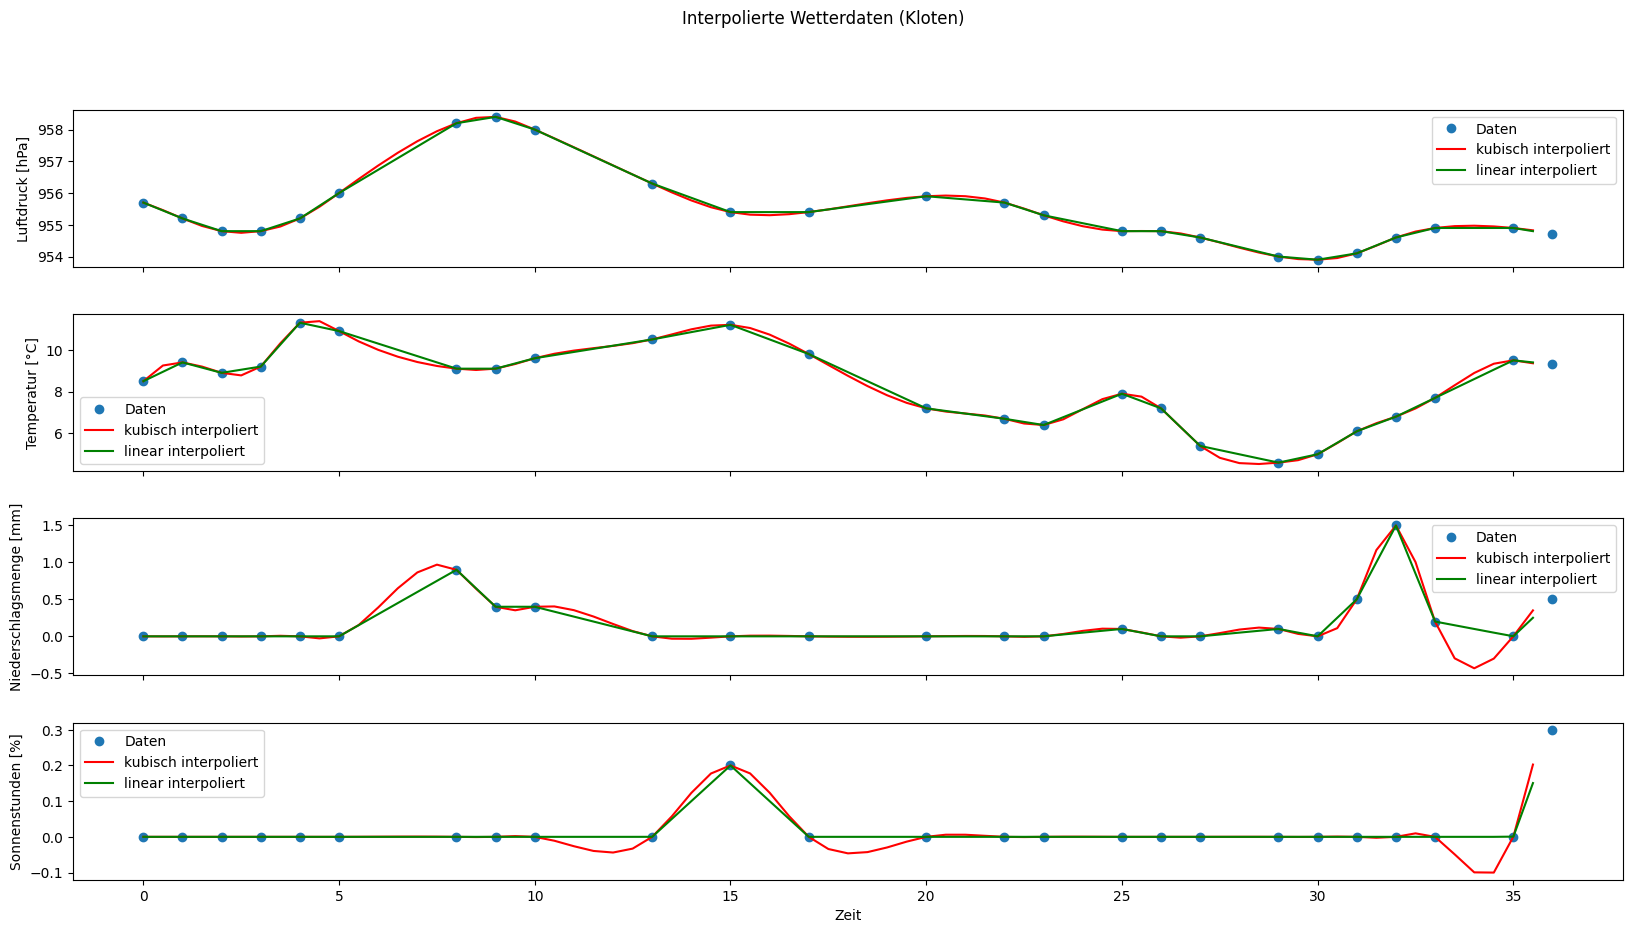

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.plot(time_diff_demo, pressure[:25], 'o', label='Daten')
ax1.plot(t[0:2*max_demo], pressure_inter_cubic[0:2*max_demo], 'r-', label='kubisch interpoliert')
ax1.plot(t[0:2*max_demo], pressure_inter_linear[0:2*max_demo], 'g-', label='linear interpoliert')
ax1.set_ylabel('Luftdruck [hPa]')
ax1.legend()

ax2.plot(time_diff_demo, temp[:25], 'o', label='Daten')
ax2.plot(t[0:2*max_demo], temp_inter_cubic[0:2*max_demo], 'r-', label='kubisch interpoliert')
ax2.plot(t[0:2*max_demo], temp_inter_linear[0:2*max_demo], 'g-', label='linear interpoliert')
ax2.set_ylabel('Temperatur [°C]')
#ax2.set_xlabel('Zeit')
ax2.legend()

ax3.plot(time_diff_demo, rain[:25], 'o', label='Daten')
ax3.plot(t[0:2*max_demo], rain_inter_cubic[0:2*max_demo], 'r-', label='kubisch interpoliert')
ax3.plot(t[0:2*max_demo], rain_inter_linear[0:2*max_demo], 'g-', label='linear interpoliert')
ax3.set_ylabel('Niederschlagsmenge [mm]') #Einheit: mm ?
#ax3.set_xlabel('Zeit')
ax3.legend()

ax4.plot(time_diff_demo, sunshine[:25], 'o', label='Daten')
ax4.plot(t[0:2*max_demo], sunshine_inter_cubic[0:2*max_demo], 'r-', label='kubisch interpoliert')
ax4.plot(t[0:2*max_demo], sunshine_inter_linear[0:2*max_demo], 'g-', label='linear interpoliert')
ax4.set_ylabel('Sonnenstunden [%]')
#ax4.set_xlabel('Zeit')
ax4.legend()

plt.xlabel('Zeit')
plt.suptitle('Interpolierte Wetterdaten (Kloten)')
plt.show()

Entscheidung: 
 Luftdruck und Temperatur -> kubisch -> Wieso????
 Niederschlagsmenge und Sonnenstunden -> linear -> bei kubisch entstehen nicht reale Daten -> negative Niederschlagsmenden und Sonnenstunden isnd nicht möglich

3. Ihr sollt alle Variablen (Luftdruck, Temperatur, Regenmenge und Sonnenstunden) über einen selbstgewählten Zeitraum darstellen. 
   - Basisvariante: Wähle einen interessanten Zeitraum von 1-2 Wochen.
   - Schwierigere Variante (mehr Punkte): Errechne tageweise Durchschnitte, um die Variablen in einem grösseren Zeitraum (mehrere Monate/Quartal) darzustellen.

In [7]:
#Variablen instanzieren
daily_pressure = np.array([]).astype(float)
daily_average_pressure = 0

daily_temp = np.array([]).astype(float)
daily_average_temp = 0

daily_rain = np.array([]).astype(float)
daily_average_rain = 0

daily_sunshine = np.array([]).astype(float)
daily_average_sun = 0


for i in range(len(t)):
    daily_average_pressure += pressure_inter_cubic[i]
    daily_average_temp += temp_inter_cubic[i]
    daily_average_rain += rain_inter_linear[i]
    daily_average_sun += sunshine_inter_linear[i]
    if (i+1) % 48 == 0:
        daily_pressure = np.append(daily_pressure, daily_average_pressure/48)
        daily_average_pressure = 0
        daily_temp = np.append(daily_temp, daily_average_temp/48)
        daily_average_temp = 0
        daily_rain = np.append(daily_rain, daily_average_rain/48)
        daily_average_rain = 0
        daily_sunshine = np.append(daily_sunshine, daily_average_sun/48)
        daily_average_sun = 0

#für den letzten Tag wird der Durchschnitt nicht gerechnet, da die letzte stunde fehlt..
#soll die letzte stunde auch noch interpoliert werden oder soll der letzte tag trotzdem gerechnet werden????????????
#if daily_average != 0:
    
print(len(daily_pressure))
print(np.mean(daily_pressure))
print(np.mean(pressure_inter_cubic))
print(np.max(daily_pressure))

print(len(daily_temp))
print(np.mean(daily_temp))
print(np.mean(temp_inter_cubic))
print(np.max(daily_temp))

print(len(daily_rain))
print(np.mean(daily_rain))
print(np.mean(rain_inter_linear))
print(np.max(daily_rain))

print(len(daily_sunshine))
print(np.mean(daily_sunshine))
print(np.mean(sunshine_inter_linear))
print(np.max(daily_sunshine))


365
968.7483276283461
968.7549391193081
987.3920407234895
365
11.28179739373919
11.285233318017687
27.020911722714022
365
0.09574226584363142
0.09551431599725967
1.3790881487807403
365
0.23730384078965652
0.23676210924119467
0.6270476326027222


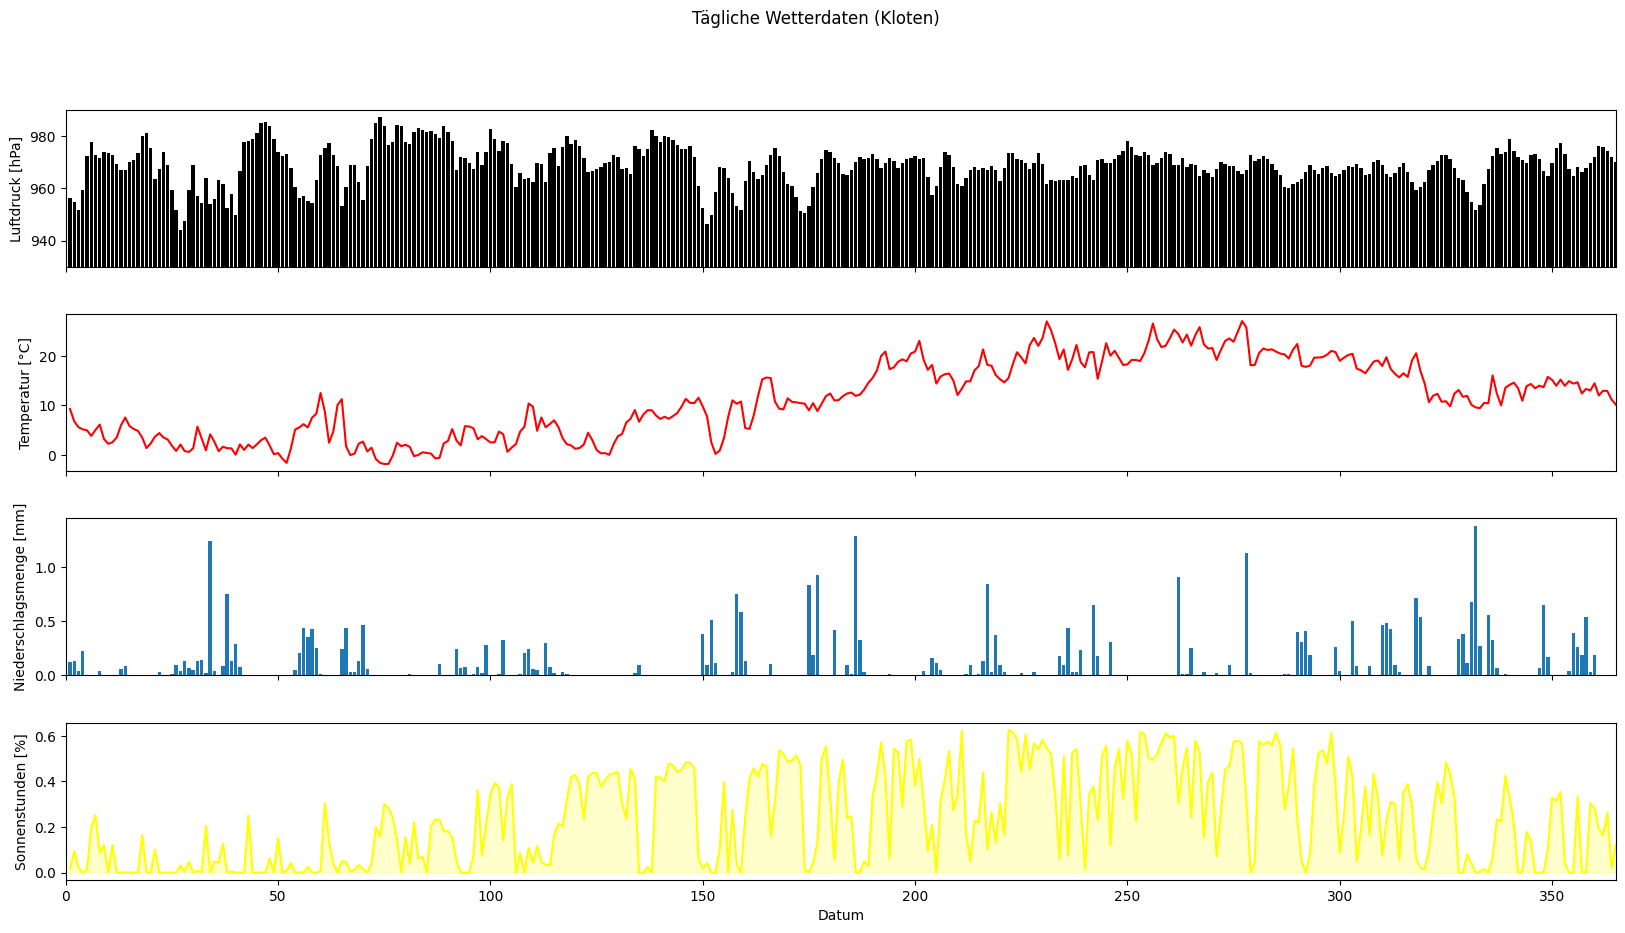

In [8]:
days = np.arange(1, len(daily_pressure)+1, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.bar(days, daily_pressure, color='black')
ax1.set_ylim(930,990)
ax1.set_ylabel('Luftdruck [hPa]')


ax2.plot(days, daily_temp, color='red')
ax2.set_ylabel('Temperatur [°C]')

ax3.bar(days, daily_rain)
ax3.set_ylabel('Niederschlagsmenge [mm]')

ax4.plot(days, daily_sunshine, color='yellow')
ax4.fill_between(days, daily_sunshine, 0, alpha=0.2, color='yellow')
#ax4.set_ylim(0,1)
ax4.set_ylabel('Sonnenstunden [%]')

plt.xlabel('Datum') #Datum fehlt noch!!!!! sind noch Tage :(
plt.xlim(0, 365)
plt.suptitle('Tägliche Wetterdaten (Kloten)')
plt.show()

4. Für die folgenden Punkte sollt ihr eine der Variablen auswählen.
   - Entweder Luftdruck, Temperatur, Regenmenge oder Sonnenstunden

Temperature it is!

5. Vergleicht die ursprünglichen Daten mit den interpolierten Daten und zeigt eure Erkenntnisse auf. 
   - Hier könnt ihr euch z.B. fragen, wie sich unterschiedliche Interpolationsmethoden verhalten.

In [9]:
f_linear_temp = interp1d(time_diff, klo_weather_t[3:4], kind = 'linear') 

6. Berechnet Nullstellen bzw. Schnittpunkte mit einem Schwellenwert und überlegt euch, welche Aussagen ihr daraus ableiten könnt.
   - Ihr könntet z.B. sagen: "In Davos hatten wir im Winter X-mal weniger als Null Grad." oder "An welchen Tagen wurde die Regenmenge XY erreicht?".

In [10]:
print(f_linear_temp(0))
zero = optimize.newton(f_linear_temp, 1000)
print(zero)
#print(temp_inter_linear[1900:2000])

zero1 = optimize.newton(f_linear_temp, 40)
print(zero1)


[8.5]
[[[[[[[988.17647059]]]]]]]
[[[[[[[[[[[223.25]]]]]]]]]]]


7. Mithilfe der Ableitung soll nach grossen Änderungen in den Daten gesucht werden. 
   - So könnt ihr z.B. sagen: "Am Tag X hatten wir die grösste Änderungsrate des Luftdrucks".

In [11]:
df = np.gradient(temp_inter_cubic)

i_min = np.argmin(df) #Returns the indices of the minimum values along an axis.
i_max = np.argmax(df) #Returns the indices of the maximum values along an axis.
print("maximale Abnahme:",(df[i_min]), "am Tag", (t[i_min])) #mwandeln in Tag fehlt noch!!!!!!!!!!!
print("maximale Zunahme:",(df[i_max]), "am Tag", (t[i_max])) #umwandeln in Tag fehlt noch!!!!!!!!!!!



maximale Abnahme: -3.7316416579804415 am Tag 6665.879476231141
maximale Zunahme: 2.315437547480432 am Tag 2769.6576715058354


In [12]:
#überprüfung der werte
print(temp_inter_cubic[i_min-2:i_min+1])
print(temp_inter_cubic[i_max-2:i_max+1])

[32.02453956 28.89901733 24.62896293]
[0.16875615 2.06162595 4.39243878]


8. Benutze die Integration, um gewisse Durchschnittswerte über einen definierten Zeitraum zu berechnen.
   - So könnt ihr z.B. die durchschnittlichen Sonnenstunden über den Sommer aufzeigen.

In [13]:
def mean_func(func, a, b):
    integral, error = integrate.quad(func, a, b)
    return integral / (b - a)

In [14]:
mean_temp = mean_func(f_linear_temp, 0, 500)
print(mean_temp)

np.mean(temp_inter_cubic[:500]) # wäre das nicht einfacher und genauer?

4.6858622096793425


/var/folders/q8/hvsp1b0j5fsbxf6r91xb9xrm0000gp/T/ipykernel_53686/4244152064.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = integrate.quad(func, a, b)


5.01382296430956

In [15]:
#Zeitraum muss noch angepasst werden
ausgewählter_zeitraum_x = t[:500]
ausgewählter_zeitraum_y = temp_inter_cubic[:500]

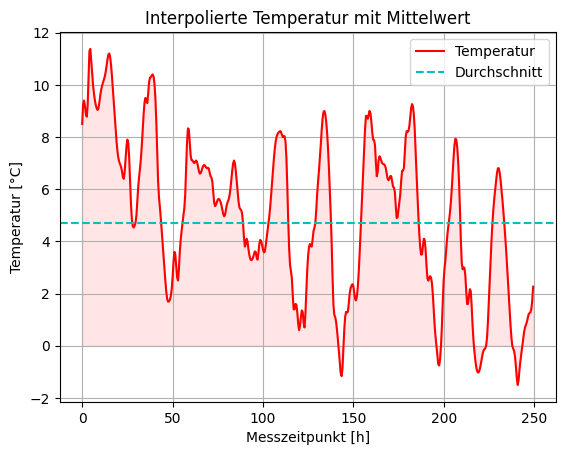

Die Durschnittstemperatur durch den Sommer betrug 4.6858622096793425 °C


In [16]:


plt.plot(ausgewählter_zeitraum_x, ausgewählter_zeitraum_y, color='red', label='Temperatur')
plt.fill_between(ausgewählter_zeitraum_x, ausgewählter_zeitraum_y, alpha=0.1, color='red')
plt.axhline(y=mean_temp, color='c', linestyle='--', label='Durchschnitt')
plt.xlabel("Messzeitpunkt [h]") #Datum fehlt noch!!!!! sind noch Stunden :(
plt.ylabel("Temperatur [°C]")
plt.title("Interpolierte Temperatur mit Mittelwert")
plt.legend()
plt.grid()
plt.show()

print("Die Durschnittstemperatur durch den Sommer betrug", mean_temp, "°C")